## Literature

https://quantpy.com.au/stochastic-calculus/brownian-motion-for-financial-mathematics/


https://www.youtube.com/watch?v=sIKD1tQryHg

https://www.quantstart.com/articles/geometric-brownian-motion-simulation-with-python/

https://towardsdatascience.com/stochastic-processes-simulation-brownian-motion-the-basics-c1d71585d9f9



### Random Walk

In [2]:
import math
import itertools
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
# Parameters
M = 10 # number of simulations
t = 10 # Time

In [ ]:
random_walk = [-1, 1]

In [ ]:
steps_wo = np.random.choice(random_walk, size = (M,t))

In [ ]:
steps = np.random.choice(random_walk, size = (M,t)).T

In [ ]:
steps_wo

array([[-1, -1, -1,  1, -1, -1, -1, -1, -1, -1],
       [-1,  1,  1,  1, -1,  1, -1, -1, -1,  1],
       [ 1,  1,  1, -1,  1, -1, -1, -1,  1, -1],
       [ 1,  1, -1,  1,  1, -1, -1, -1, -1,  1],
       [-1,  1, -1,  1,  1, -1, -1,  1, -1,  1],
       [ 1,  1, -1, -1,  1,  1,  1, -1,  1, -1],
       [-1, -1, -1,  1,  1,  1,  1,  1,  1, -1],
       [ 1,  1, -1, -1,  1,  1,  1, -1, -1,  1],
       [ 1,  1, -1,  1, -1, -1, -1, -1,  1, -1],
       [ 1,  1,  1, -1, -1, -1,  1, -1, -1,  1]])

In [ ]:
steps

array([[ 1, -1, -1,  1, -1, -1, -1,  1, -1, -1],
       [-1, -1,  1, -1, -1,  1,  1,  1, -1,  1],
       [ 1, -1, -1,  1,  1,  1,  1,  1,  1,  1],
       [ 1,  1,  1, -1, -1,  1, -1,  1,  1,  1],
       [-1,  1, -1, -1,  1,  1, -1,  1,  1, -1],
       [ 1, -1,  1, -1,  1,  1,  1,  1, -1, -1],
       [-1,  1,  1, -1, -1,  1, -1,  1,  1, -1],
       [ 1,  1,  1, -1, -1,  1, -1,  1, -1, -1],
       [ 1,  1, -1, -1,  1,  1, -1,  1, -1, -1],
       [ 1, -1,  1, -1, -1, -1,  1, -1,  1, -1]])

In [ ]:
origin = np.zeros((1,M))
origin

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
np.concatenate([origin, steps])

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.],
       [-1., -1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.],
       [ 1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.],
       [-1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1., -1.],
       [ 1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.],
       [-1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1., -1.],
       [ 1.,  1.,  1., -1., -1.,  1., -1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.],
       [ 1., -1.,  1., -1., -1., -1.,  1., -1.,  1., -1.]])

In [ ]:
rw_paths = np.concatenate([origin, steps]).cumsum(axis=0)
rw_paths

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1.],
       [ 0., -2.,  0.,  0., -2.,  0.,  0.,  2., -2.,  0.],
       [ 1., -3., -1.,  1., -1.,  1.,  1.,  3., -1.,  1.],
       [ 2., -2.,  0.,  0., -2.,  2.,  0.,  4.,  0.,  2.],
       [ 1., -1., -1., -1., -1.,  3., -1.,  5.,  1.,  1.],
       [ 2., -2.,  0., -2.,  0.,  4.,  0.,  6.,  0.,  0.],
       [ 1., -1.,  1., -3., -1.,  5., -1.,  7.,  1., -1.],
       [ 2.,  0.,  2., -4., -2.,  6., -2.,  8.,  0., -2.],
       [ 3.,  1.,  1., -5., -1.,  7., -3.,  9., -1., -3.],
       [ 4.,  0.,  2., -6., -2.,  6., -2.,  8.,  0., -4.]])

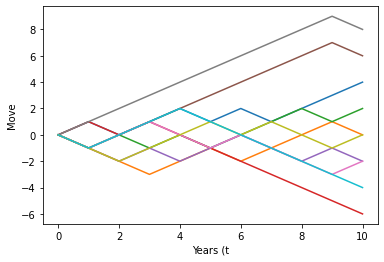

In [ ]:
plt.plot(rw_paths)
plt.xlabel("Years (t")
plt.ylabel("Move")
plt.show()

In [ ]:
# Parameters
M = 100000
t = 10
n = 10

random_walk = [-1, 1]


In [ ]:
steps = (1/np.sqrt(n)) * np.random.choice(random_walk, size =(M, t*n)).T


In [ ]:
origin = np.zeros((1,M))
srw_paths = np.concatenate([origin, steps]).cumsum(axis=0)

In [ ]:
time = np.linspace(0,t,t*n+1)

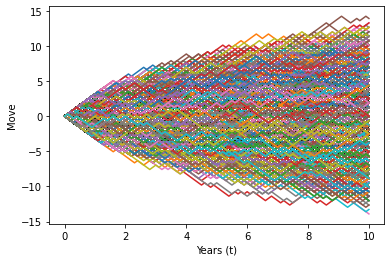

In [ ]:
tt = np.full(shape=(M, t*n+1), fill_value=time)
tt = tt.T
# print(np.size(tt),np.size(srw_paths))
plt.plot(tt,srw_paths)
plt.xlabel("Years (t)")
plt.ylabel("Move")
plt.show()


### Brownian motion

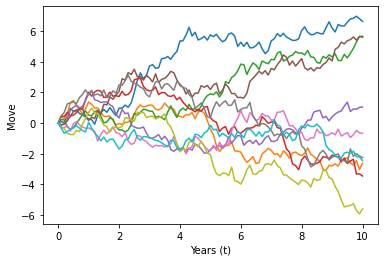

In [3]:
# Parameters
M = 10 # number of simulations
t = 10 # Time
n = 100 # steps we want to see
dt = t/n # time step

steps = np.random.normal(0, np.sqrt(dt), size=(M, n)).T
origin = np.zeros((1,M))
bm_paths = np.concatenate([origin, steps]).cumsum(axis=0)

time = np.linspace(0,t,n+1)
tt = np.full(shape=(M, n+1), fill_value=time)
tt = tt.T

plt.plot(tt,bm_paths)
plt.xlabel("Years (t)")
plt.ylabel("Move")
plt.show()

### Generating Geometric Brownian motion


In [7]:
 tt.shape

(101, 10)

In [8]:
# gbm.py

import os
import random
import string

import click
import numpy as np
import pandas as pd


class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    open-high-low-close-volume (OHLCV) based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion for pricing
    and a Pareto distribution for volume.

    It will output the results to a CSV with a randomly generated
    ticker smbol.

    For now the tool is hardcoded to generate business day daily
    data between two dates, inclusive.

    Note that the pricing and volume data is completely uncorrelated,
    which is not likely to be the case in real asset paths.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    output_dir : `str`
        The full path to the output directory for the CSV.
    symbol_length : `int`
        The length of the ticker symbol to use.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    pareto_shape : `float`
        The parameter used to govern the Pareto distribution
        shape for the generation of volume data.
    """

    def __init__(
        self,
        start_date,
        end_date,
        output_dir,
        symbol_length,
        init_price,
        mu,
        sigma,
        pareto_shape
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.output_dir = output_dir
        self.symbol_length = symbol_length
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma
        self.pareto_shape = pareto_shape

    def _generate_random_symbol(self):
        """
        Generates a random ticker symbol string composed of
        uppercase ASCII characters to use in the CSV output filename.

        Returns
        -------
        `str`
            The random ticker string composed of uppercase letters.
        """
        return ''.join(
            random.choices(
                string.ascii_uppercase,
                k=self.symbol_length
            )
        )

    def _create_empty_frame(self):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price/volume
        columns are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty OHLCV DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        zeros = pd.Series(np.zeros(len(date_range)))

        return pd.DataFrame(
            {
                'date': date_range,
                'open': zeros,
                'high': zeros,
                'low': zeros,
                'close': zeros,
                'volume': zeros
            }
        )[['date', 'open', 'high', 'low', 'close', 'volume']]

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates an asset price path using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        This divides the usual timestep by four so that the pricing
        series is four times as long, to account for the need to have
        an open, high, low and close price for each day. These prices
        are subsequently correctly bounded in a further method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `np.ndarray`
            The asset price path (four times as long to include OHLC).
        """
        n = len(data)
        T = n / 252.0  # Business days in a year
        dt = T / (4.0 * n)  # 4.0 is needed as four prices per day are required
        
        # Vectorised implementation of asset path generation
        # including four prices per day, used to create OHLC
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size=(4 * n))
        )
        
        return self.init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path):
        """
        Correctly accounts for the max/min calculations required
        to generate a correct high and low price for a particular
        day's pricing.

        The open price takes every fourth value, while the close
        price takes every fourth value offset by 3 (last value in
        every block of four).

        The high and low prices are calculated by taking the max
        (resp. min) of all four prices within a day and then
        adjusting these values as necessary.

        This is all carried out in place so the frame is not returned
        via the method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The price/volume DataFrame to modify in place.
        path : `np.ndarray`
            The original NumPy array of the asset price path.
        """
        data['open'] = path[0::4]
        data['close'] = path[3::4]

        data['high'] = np.maximum(
            np.maximum(path[0::4], path[1::4]),
            np.maximum(path[2::4], path[3::4])
        )

        data['low'] = np.minimum(
            np.minimum(path[0::4], path[1::4]),
            np.minimum(path[2::4], path[3::4])
        )

    def _append_volume_to_data(self, data):
        """
        Utilises a Pareto distribution to simulate non-negative
        volume data. Note that this is not correlated to the
        underlying asset price, as would likely be the case for
        real data, but it is a reasonably effective approximation.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame to append volume data to, in place.
        """
        data['volume'] = np.array(
            list(
                map(
                    int,
                    np.random.pareto(
                        self.pareto_shape,
                        size=len(data)
                    ) * 1000000.0
                )
            )
        )

    def _output_frame_to_dir(self, symbol, data):
        """
        Output the fully-populated DataFrame to disk into the
        desired output directory, ensuring to trim all pricing
        values to two decimal places.

        Parameters
        ----------
        symbol : `str`
            The ticker symbol to name the file with.
        data : `pd.DataFrame`
            The DataFrame containing the generated OHLCV data.
        """
        output_file = os.path.join(self.output_dir, '%s.csv' % symbol)
        data.to_csv(output_file, index=False, float_format='%.2f')

    def __call__(self):
        """
        The entrypoint for generating the asset OHLCV frame. Firstly this
        generates a symbol and an empty frame. It then populates this
        frame with some simulated GBM data. The asset volume is then appended
        to this data and finally it is saved to disk as a CSV.
        """
        symbol = self._generate_random_symbol()
        data = self._create_empty_frame()
        path = self._create_geometric_brownian_motion(data)
        self._append_path_to_data(data, path)
        self._append_volume_to_data(data)
        self._output_frame_to_dir(symbol, data)


@click.command()
@click.option('--num-assets', 'num_assets', default='1', help='Number of separate assets to generate files for')
@click.option('--random-seed', 'random_seed', default='42', help='Random seed to set for both Python and NumPy for reproducibility')
@click.option('--start-date', 'start_date', default=None, help='The starting date for generating the synthetic data in YYYY-MM-DD format')
@click.option('--end-date', 'end_date', default=None, help='The starting date for generating the synthetic data in YYYY-MM-DD format')
@click.option('--output-dir', 'output_dir', default=None, help='The location to output the synthetic data CSV file to')
@click.option('--symbol-length', 'symbol_length', default='5', help='The length of the asset symbol using uppercase ASCII characters')
@click.option('--init-price', 'init_price', default='100.0', help='The initial stock price to use')
@click.option('--mu', 'mu', default='0.1', help='The drift parameter, \mu for the GBM SDE')
@click.option('--sigma', 'sigma', default='0.3', help='The volatility parameter, \sigma for the GBM SDE')
@click.option('--pareto-shape', 'pareto_shape', default='1.5', help='The shape of the Pareto distribution simulating the trading volume')
def cli(num_assets, random_seed, start_date, end_date, output_dir, symbol_length, init_price, mu, sigma, pareto_shape):
    num_assets = int(num_assets)
    random_seed = int(random_seed)
    symbol_length = int(symbol_length)
    init_price = float(init_price)
    mu = float(mu)
    sigma = float(sigma)
    pareto_shape = float(pareto_shape)

    # Need to seed both Python and NumPy separately
    random.seed(random_seed)
    np.random.seed(seed=random_seed)

    gbmas = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        output_dir,
        symbol_length,
        init_price,
        mu,
        sigma,
        pareto_shape
    )

    # Create num_assets files by repeatedly calling
    # the instantiated class
    for i in range(num_assets):
        print('Generating asset path %d of %d...' % (i+1, num_assets))
        gbmas()


if __name__ == "__main__":
    cli()


Usage: ipykernel_launcher.py [OPTIONS]
Try 'ipykernel_launcher.py --help' for help.

Error: no such option: -f


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# gbm.py

import os
import random
import string

import click
import numpy as np
import pandas as pd


class GeometricBrownianMotionAssetSimulator:
    """
    This callable class will generate a daily
    open-high-low-close-volume (OHLCV) based DataFrame to simulate
    asset pricing paths with Geometric Brownian Motion for pricing
    and a Pareto distribution for volume.

    It will output the results to a CSV with a randomly generated
    ticker smbol.

    For now the tool is hardcoded to generate business day daily
    data between two dates, inclusive.

    Note that the pricing and volume data is completely uncorrelated,
    which is not likely to be the case in real asset paths.

    Parameters
    ----------
    start_date : `str`
        The starting date in YYYY-MM-DD format.
    end_date : `str`
        The ending date in YYYY-MM-DD format.
    output_dir : `str`
        The full path to the output directory for the CSV.
    symbol_length : `int`
        The length of the ticker symbol to use.
    init_price : `float`
        The initial price of the asset.
    mu : `float`
        The mean 'drift' of the asset.
    sigma : `float`
        The 'volatility' of the asset.
    pareto_shape : `float`
        The parameter used to govern the Pareto distribution
        shape for the generation of volume data.
    """

    def __init__(
        self,
        start_date,
        end_date,
        symbol_length,
        init_price,
        mu,
        sigma,
    ):
        self.start_date = start_date
        self.end_date = end_date
        self.symbol_length = symbol_length
        self.init_price = init_price
        self.mu = mu
        self.sigma = sigma

    def _generate_random_symbol(self):
        """
        Generates a random ticker symbol string composed of
        uppercase ASCII characters to use in the CSV output filename.

        Returns
        -------
        `str`
            The random ticker string composed of uppercase letters.
        """
        return ''.join(
            random.choices(
                string.ascii_uppercase,
                k=self.symbol_length
            )
        )

    def _create_empty_frame(self):
        """
        Creates the empty Pandas DataFrame with a date column using
        business days between two dates. Each of the price/volume
        columns are set to zero.

        Returns
        -------
        `pd.DataFrame`
            The empty OHLCV DataFrame for subsequent population.
        """
        date_range = pd.date_range(
            self.start_date,
            self.end_date,
            freq='B'
        )

        zeros = pd.Series(np.zeros(len(date_range)))

        return pd.DataFrame(
            {
                'date': date_range,
                'open': zeros,
                'high': zeros,
                'low': zeros,
                'close': zeros,
                'volume': zeros
            }
        )[['date', 'open', 'high', 'low', 'close', 'volume']]

    def _create_geometric_brownian_motion(self, data):
        """
        Calculates an asset price path using the analytical solution
        to the Geometric Brownian Motion stochastic differential
        equation (SDE).

        This divides the usual timestep by four so that the pricing
        series is four times as long, to account for the need to have
        an open, high, low and close price for each day. These prices
        are subsequently correctly bounded in a further method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame needed to calculate length of the time series.

        Returns
        -------
        `np.ndarray`
            The asset price path (four times as long to include OHLC).
        """
        n = len(data)
        T = n / 252.0  # Business days in a year
        dt = T / (4.0 * n)  # 4.0 is needed as four prices per day are required
        
        # Vectorised implementation of asset path generation
        # including four prices per day, used to create OHLC
        asset_path = np.exp(
            (self.mu - self.sigma**2 / 2) * dt +
            self.sigma * np.random.normal(0, np.sqrt(dt), size=(4 * n))
        )
        
        return self.init_price * asset_path.cumprod()

    def _append_path_to_data(self, data, path):
        """
        Correctly accounts for the max/min calculations required
        to generate a correct high and low price for a particular
        day's pricing.

        The open price takes every fourth value, while the close
        price takes every fourth value offset by 3 (last value in
        every block of four).

        The high and low prices are calculated by taking the max
        (resp. min) of all four prices within a day and then
        adjusting these values as necessary.

        This is all carried out in place so the frame is not returned
        via the method.

        Parameters
        ----------
        data : `pd.DataFrame`
            The price/volume DataFrame to modify in place.
        path : `np.ndarray`
            The original NumPy array of the asset price path.
        """
        data['open'] = path[0::4]
        data['close'] = path[3::4]

        data['high'] = np.maximum(
            np.maximum(path[0::4], path[1::4]),
            np.maximum(path[2::4], path[3::4])
        )

        data['low'] = np.minimum(
            np.minimum(path[0::4], path[1::4]),
            np.minimum(path[2::4], path[3::4])
        )

    def _append_volume_to_data(self, data):
        """
        Utilises a Pareto distribution to simulate non-negative
        volume data. Note that this is not correlated to the
        underlying asset price, as would likely be the case for
        real data, but it is a reasonably effective approximation.

        Parameters
        ----------
        data : `pd.DataFrame`
            The DataFrame to append volume data to, in place.
        """
        data['volume'] = np.array(
            list(
                map(
                    int,
                    np.random.pareto(
                        self.pareto_shape,
                        size=len(data)
                    ) * 1000000.0
                )
            )
        )

    def _output_frame_to_dir(self, symbol, data):
        """
        Output the fully-populated DataFrame to disk into the
        desired output directory, ensuring to trim all pricing
        values to two decimal places.

        Parameters
        ----------
        symbol : `str`
            The ticker symbol to name the file with.
        data : `pd.DataFrame`
            The DataFrame containing the generated OHLCV data.
        """
        output_file = os.path.join(self.output_dir, '%s.csv' % symbol)
        data.to_csv(output_file, index=False, float_format='%.2f')

    def __call__(self):
        """
        The entrypoint for generating the asset OHLCV frame. Firstly this
        generates a symbol and an empty frame. It then populates this
        frame with some simulated GBM data. The asset volume is then appended
        to this data and finally it is saved to disk as a CSV.
        """
        symbol = self._generate_random_symbol()
        data = self._create_empty_frame()
        path = self._create_geometric_brownian_motion(data)
        self._append_path_to_data(data, path)
        self._append_volume_to_data(data)
        self._output_frame_to_dir(symbol, data)


@click.command()
@click.option('--num-assets', 'num_assets', default='1', help='Number of separate assets to generate files for')
@click.option('--random-seed', 'random_seed', default='42', help='Random seed to set for both Python and NumPy for reproducibility')
@click.option('--start-date', 'start_date', default=None, help='The starting date for generating the synthetic data in YYYY-MM-DD format')
@click.option('--end-date', 'end_date', default=None, help='The starting date for generating the synthetic data in YYYY-MM-DD format')
@click.option('--output-dir', 'output_dir', default=None, help='The location to output the synthetic data CSV file to')
@click.option('--symbol-length', 'symbol_length', default='5', help='The length of the asset symbol using uppercase ASCII characters')
@click.option('--init-price', 'init_price', default='100.0', help='The initial stock price to use')
@click.option('--mu', 'mu', default='0.1', help='The drift parameter, \mu for the GBM SDE')
@click.option('--sigma', 'sigma', default='0.3', help='The volatility parameter, \sigma for the GBM SDE')
@click.option('--pareto-shape', 'pareto_shape', default='1.5', help='The shape of the Pareto distribution simulating the trading volume')
def cli(num_assets, random_seed, start_date, end_date, output_dir, symbol_length, init_price, mu, sigma, pareto_shape):
    num_assets = int(num_assets)
    random_seed = int(random_seed)
    symbol_length = int(symbol_length)
    init_price = float(init_price)
    mu = float(mu)
    sigma = float(sigma)
    pareto_shape = float(pareto_shape)

    # Need to seed both Python and NumPy separately
    random.seed(random_seed)
    np.random.seed(seed=random_seed)

    gbmas = GeometricBrownianMotionAssetSimulator(
        start_date,
        end_date,
        output_dir,
        symbol_length,
        init_price,
        mu,
        sigma,
        pareto_shape
    )

    # Create num_assets files by repeatedly calling
    # the instantiated class
    for i in range(num_assets):
        print('Generating asset path %d of %d...' % (i+1, num_assets))
        gbmas()


if __name__ == "__main__":
    cli()
